In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.1871],
         [-0.5227]]),
 tensor([[ 1.0000e+00,  1.1871e+00,  7.0460e-01,  2.7881e-01,  8.2742e-02,
           1.9645e-02,  3.8867e-03,  6.5912e-04,  9.7804e-05,  1.2900e-05,
           1.5314e-06,  1.6526e-07,  1.6349e-08,  1.4929e-09,  1.2658e-10,
           1.0018e-11,  7.4326e-13,  5.1901e-14,  3.4228e-15,  2.1385e-16],
         [ 1.0000e+00, -5.2267e-01,  1.3659e-01, -2.3798e-02,  3.1096e-03,
          -3.2506e-04,  2.8317e-05, -2.1143e-06,  1.3814e-07, -8.0223e-09,
           4.1930e-10, -1.9923e-11,  8.6778e-13, -3.4890e-14,  1.3026e-15,
          -4.5387e-17,  1.4827e-18, -4.5585e-20,  1.3237e-21, -3.6413e-23]]),
 tensor([5.4893, 3.6787]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.002284   1.2074664 -3.401062   5.5828505]]


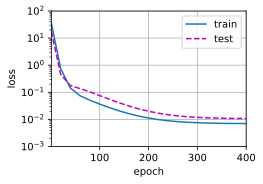

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.4555275 4.926888 ]]


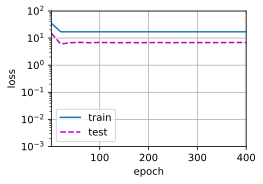

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9828219e+00  1.2902341e+00 -3.2716653e+00  5.1871400e+00
  -4.8286760e-01  5.2622223e-01  3.2533184e-01  6.3629702e-02
   2.0467240e-01 -1.4823056e-02 -2.0081358e-01 -1.8720244e-01
  -1.8830324e-02  2.7577240e-02  2.1766955e-02 -2.1305081e-01
  -1.2853168e-01  1.9171491e-03  6.0085762e-02 -2.0699620e-01]]


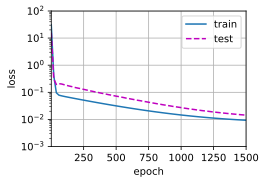

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

In [22]:
labels.shape

torch.Size([200])

In [16]:
[true_w, features, poly_features, labels]

[array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]),
 array([[-6.39635549e-01],
        [-9.71116009e-01],
        [ 1.87199987e+00],
        [-1.72255931e+00],
        [-5.92840277e-01],
        [ 1.04273993e+00],
        [ 9.93895305e-01],
        [-1.48776668e+00],
        [-5.18759620e-01],
        [-1.00329388e+00],
        [ 2.11019090e+00],
        [-4.77167753e-01],
        [-1.22797070e-01],
        [ 1.42034422e+00],
        [-1.44644094e-02],
        [ 1.57932362e-01],
        [ 8.84722725e-01],
        [-7.99709431e-01],
        [ 1.68988602e+00],
        [ 7.97941401e-02],
        [-8.05311085e-01],
        [ 4.82419315e-01],
        [ 1.04137139e-01],
        [-1.08055846e+00],
        [ 1.12525408e-01],
        [ 8.63538412e-02],
        [-6.22775729e-01],
        [ 1.62983662e+00],
        [ 3.02774450e-01],
        [-7.56762961e-01],
        [-1.98561223e-01],
        [-1.95946959e+00]

In [3]:
true_w

array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

In [10]:
features

array([[-0.7313753 ],
       [ 1.1888219 ],
       [ 0.62269277],
       [-0.55404467],
       [-0.16363963],
       [-0.99258684],
       [ 0.43316168],
       [-0.13113402],
       [-0.50869452],
       [ 0.90095795],
       [-1.88877427],
       [-0.70880177],
       [-0.30082   ],
       [-0.37947762],
       [-1.04438572],
       [-0.77293417],
       [ 0.96383806],
       [-0.42449967],
       [-1.99121555],
       [ 0.96179065],
       [-0.11527553],
       [ 1.1690341 ],
       [ 0.82254863],
       [ 2.6157936 ],
       [-0.75735029],
       [ 2.143877  ],
       [ 0.72927591],
       [-0.95118091],
       [ 0.27069831],
       [-1.65049809],
       [ 0.7057038 ],
       [-0.42590854],
       [ 0.24179826],
       [ 0.37189809],
       [ 1.84931424],
       [-0.96047164],
       [ 1.46265911],
       [-1.76720997],
       [-0.29994319],
       [ 0.88885779],
       [ 0.86767969],
       [-0.67786701],
       [ 0.03770683],
       [ 2.06160433],
       [-0.96024434],
       [-0

In [6]:
np.arange(max_degree).reshape(1, -1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [7]:
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

In [12]:
poly_features[:,1]

array([-0.7313753 ,  1.1888219 ,  0.62269277, -0.55404467, -0.16363963,
       -0.99258684,  0.43316168, -0.13113402, -0.50869452,  0.90095795,
       -1.88877427, -0.70880177, -0.30082   , -0.37947762, -1.04438572,
       -0.77293417,  0.96383806, -0.42449967, -1.99121555,  0.96179065,
       -0.11527553,  1.1690341 ,  0.82254863,  2.6157936 , -0.75735029,
        2.143877  ,  0.72927591, -0.95118091,  0.27069831, -1.65049809,
        0.7057038 , -0.42590854,  0.24179826,  0.37189809,  1.84931424,
       -0.96047164,  1.46265911, -1.76720997, -0.29994319,  0.88885779,
        0.86767969, -0.67786701,  0.03770683,  2.06160433, -0.96024434,
       -0.57231451,  1.47268229, -0.21244771,  0.29519315,  0.48045927,
       -1.40334393,  1.51195051, -0.66343884, -0.52068651,  0.24825224,
        0.39843668,  0.03885158, -0.6651249 , -1.86589132, -0.52314476,
        1.05276823,  1.0790165 , -0.21942383,  1.84243519,  1.40199966,
        0.70399664, -0.88699798,  0.29088813, -0.0372594 , -0.67